In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

2025-01-10 23:05:48.271085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 23:05:48.277115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 23:05:48.341900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 23:05:48.407736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736546748.463668   43265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736546748.48

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


W0000 00:00:1736546751.088667   43265 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [ ]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

# Select data for training

In [5]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

16000

In [6]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


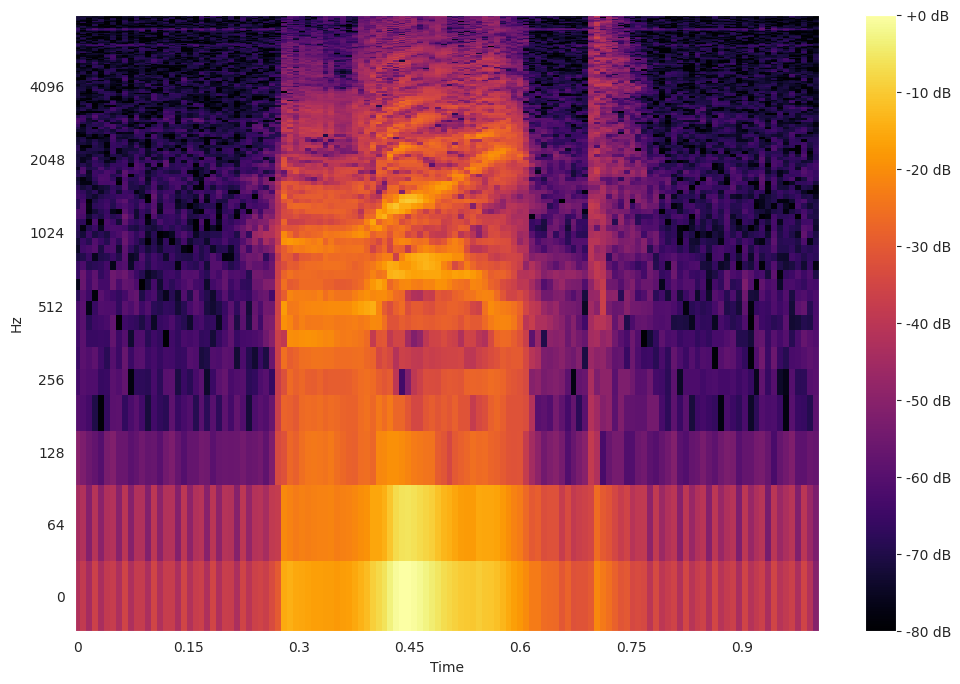

In [7]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

In [ ]:
unique, counts = np.unique(labels, return_counts=True)

plt.bar(commands, counts)

# Split data into data and labels

In [9]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

# Normalize PCM audio vectors

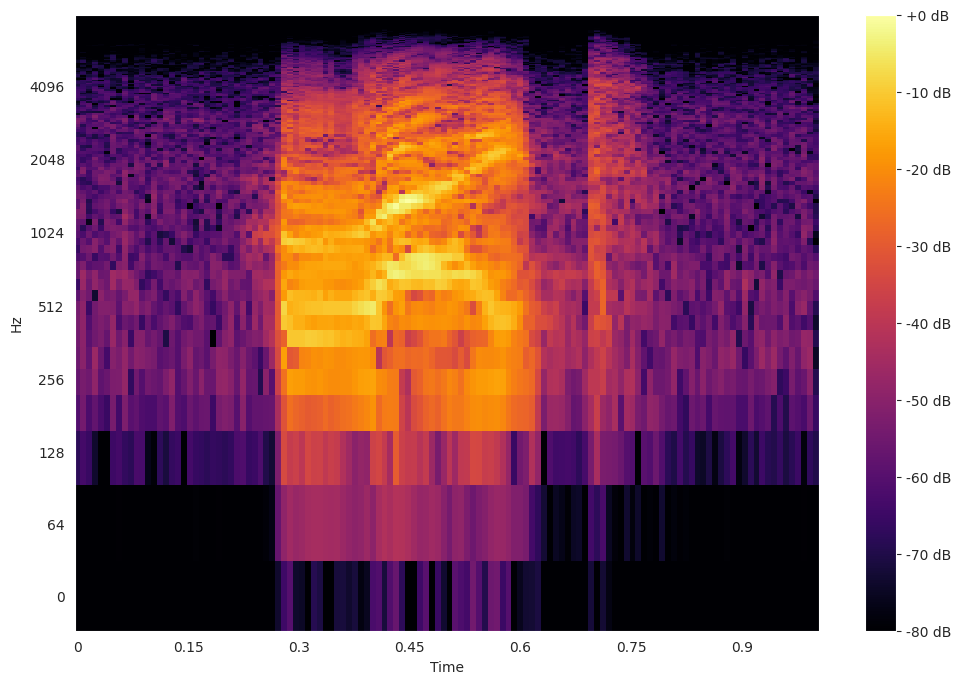

In [11]:
train_data.dtype

In [12]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= train_data_max
    print(i)
    
for i in range(len(val_data)):
    val_data[i] /= valid_data_max
    print(i)
    
for i in range(len(test_data)):
    test_data[i] /= test_data_max
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

# Spectrograms

In [14]:
def get_spectrogram(pcm):
    D = librosa.stft(pcm, n_fft=256, hop_length=128, window='hann')
    return np.abs(D)

(1, 129, 126, 1)

In [ ]:
train_data = np.array([get_spectrogram(x) for x in train_data])
valid_data = np.array([get_spectrogram(x) for x in val_data])
test_data = np.array([get_spectrogram(x) for x in test_data])

In [15]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

ValueError: File not found: filepath=tra_prototype_model.keras. Please ensure the file is an accessible `.keras` zip file.

# Model

In [95]:

# Update input shape
input_shape = train_data[0].shape  # This will now be (129, 126, 1)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(train_data)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(128, 3, activation='leaky_relu'),
    layers.Conv2D(64, 3, activation='leaky_relu'),
    layers.Conv2D(32, 3, activation='leaky_relu'),
    layers.Conv2D(16, 1, activation='leaky_relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [96]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [97]:
train_labels = train_labels.astype(np.float32)
valid_labels = val_labels.astype(np.float32)

Predicted word: right


/tmp/ipykernel_21892/237502318.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Predicted word: {selected_labels_dict.get(float(y_pred))}")


In [ ]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    batch_size=512
)

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
raw_test_data, raw_data_label = next(iter(dataset["test"].take(1)))

In [ ]:
display.Audio(raw_test_data.numpy(), rate=16000)

In [ ]:
# Add batch dimension to the first sample of test_data
sample = test_data[0]


img_array = tf.expand_dims(sample, 0)
print(img_array.shape)

prediction = np.argmax(model.predict(img_array), axis=1)
print(f"Prediction: {prediction}")

In [ ]:
results = model.evaluate(test_data, test_labels, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
y_pred = np.argmax(model.predict(test_data), axis=1)

In [ ]:
import seaborn as sns

In [ ]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model.save("/home/vistek528/TRA_PROJ/NET_prototype/tra_prototype_model.h5")